In [ ]:
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from scipy.special import softmax
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Wczytanie modelu i tokenizerów
MODEL = "cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL).to(device)
labels = {0:'negative', 1:'neutral', 2:'positive'}

# Wczytanie 1000 losowych wierszy z CSV
df = pd.read_csv("test_dataset.csv").reset_index(drop=True)

# Funkcja klasyfikująca tekst
def classify_sentiment(text):
    encoded_input = tokenizer(text, return_tensors='pt', truncation=True, padding=True,
        max_length=512).to(device)
    with torch.no_grad():
        output = model(**encoded_input)
    scores = output.logits[0].detach().cpu().numpy()
    scores = softmax(scores)
    return labels[scores.argmax()]

df = df[df['review_text'].notnull()]  
df['predicted_label'] = df['review_text'].apply(classify_sentiment)

Using device: cuda


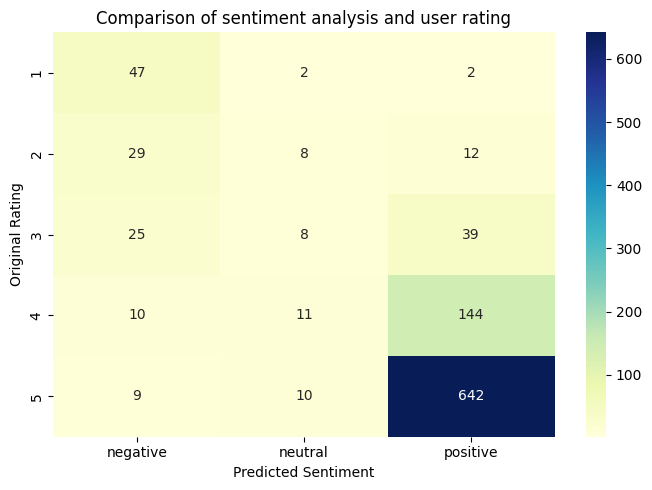

In [30]:
pivot = pd.crosstab(df['rating'], df['predicted_label'])
plt.figure(figsize=(7, 5))
sns.heatmap(pivot, annot=True, fmt='d', cmap='YlGnBu')
plt.title('Comparison of sentiment analysis and user rating')
plt.xlabel('Predicted Sentiment')
plt.ylabel('Original Rating')
plt.tight_layout()
plt.show()

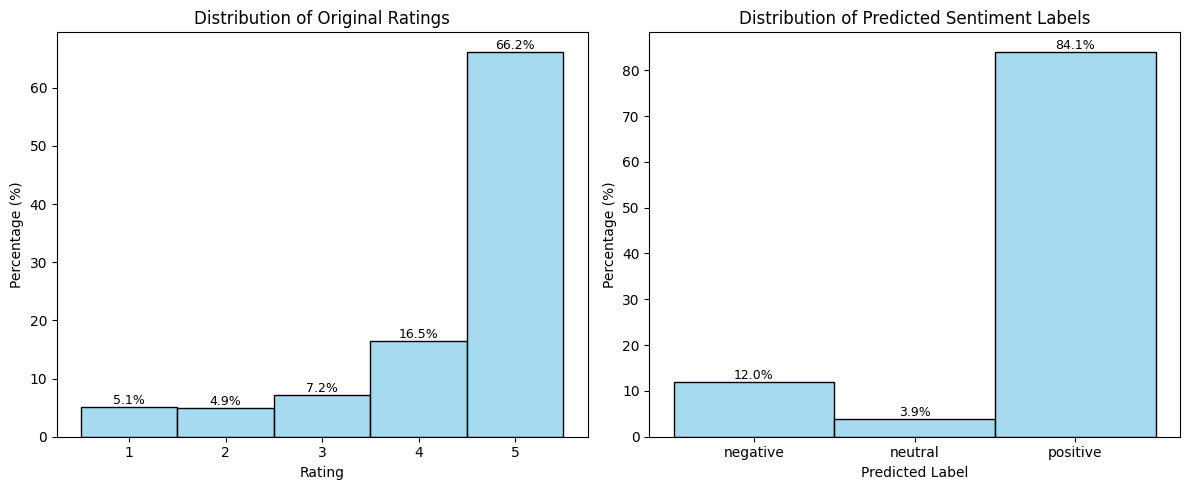

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Histogram oryginalnych ratingów (z normalizacją do procentów)
plt.subplot(1, 2, 1)
ax1 = sns.histplot(df['rating'], discrete=True, stat='percent', color='skyblue')
ax1.set_title('Distribution of Original Ratings')
ax1.set_xlabel('Rating')
ax1.set_ylabel('Percentage (%)')

# Dodanie wartości procentowych na słupkach
for p in ax1.patches:
    height = p.get_height()
    ax1.annotate(f'{height:.1f}%', (p.get_x() + p.get_width() / 2, height),
                 ha='center', va='bottom', fontsize=9)

# Histogram predykcji sentymentu (z normalizacją do procentów)
plt.subplot(1, 2, 2)
df['predicted_label'] = pd.Categorical(df['predicted_label'], categories=['negative', 'neutral', 'positive'], ordered=True)
ax2 = sns.histplot(df['predicted_label'], stat='percent', color='skyblue')
ax2.set_title('Distribution of Predicted Sentiment Labels')
ax2.set_xlabel('Predicted Label')
ax2.set_ylabel('Percentage (%)')

for p in ax2.patches:
    height = p.get_height()
    ax2.annotate(f'{height:.1f}%', (p.get_x() + p.get_width() / 2, height),
                 ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()


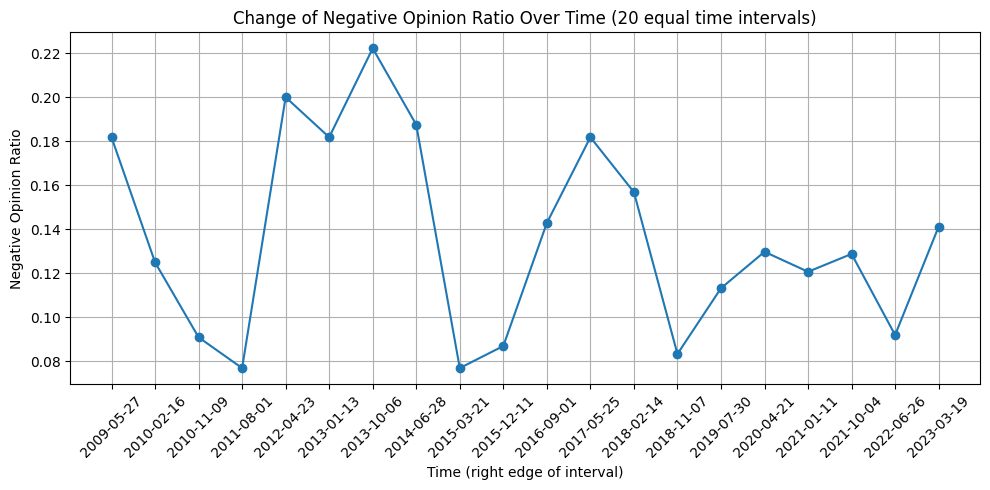

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df['date'] = pd.to_datetime(df['submission_time'], format='%Y-%m-%d')
df_filtered = df[df['predicted_label'].isin(['negative', 'positive'])].copy()

df_filtered['time_bin'] = pd.cut(df_filtered['date'], bins=20)

counts = df_filtered.groupby(['time_bin', 'predicted_label'], observed=False).size().unstack(fill_value=0)


counts['neg_to_pos_ratio'] = counts['negative'] / (counts['positive']+counts['negative'])
counts['neg_to_pos_ratio'] = counts['neg_to_pos_ratio']

bin_right_edges = counts.index.map(lambda x: x.right)

plt.figure(figsize=(10, 5))
plt.plot(bin_right_edges, counts['neg_to_pos_ratio'], marker='o')
plt.title('Change of Negative Opinion Ratio Over Time (20 equal time intervals)')
plt.xlabel('Time (right edge of interval)')
plt.xticks(bin_right_edges)
plt.ylabel('Negative Opinion Ratio')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


Tu jest plan by można było tak agregować po dowolnym id np sklep, uzytkownik kategoria produktów

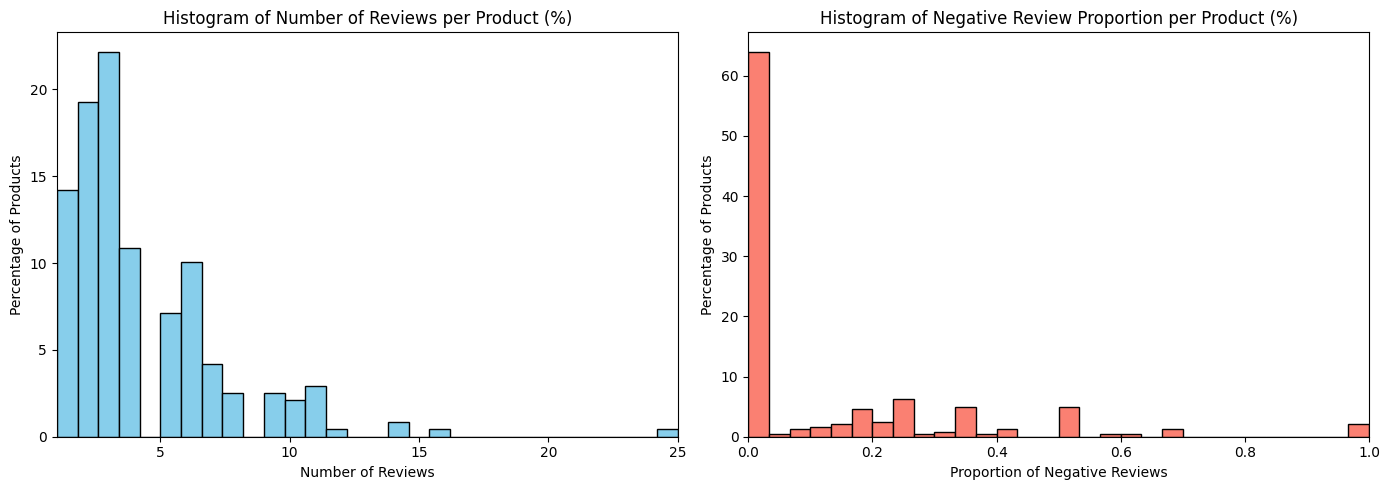

In [54]:
import matplotlib.pyplot as plt
import numpy as np

grouped = df.groupby('product_id')

reviews_count = grouped.size()
negative_count = df.groupby('product_id')['predicted_label'].apply(lambda x: (x == 'negative').sum())
negative_ratio = negative_count / reviews_count

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram liczby opinii - procentowy
counts, bins = np.histogram(reviews_count, bins=30)
percentages = counts / counts.sum() * 100

axes[0].bar(bins[:-1], percentages, width=np.diff(bins), align='edge', color='skyblue', edgecolor='black')
axes[0].set_title('Histogram of Number of Reviews per Product (%)')
axes[0].set_xlabel('Number of Reviews')
axes[0].set_ylabel('Percentage of Products')
axes[0].set_xlim(bins[0], bins[-1])

# Histogram proporcji negatywnych opinii - procentowy
counts2, bins2 = np.histogram(negative_ratio, bins=30)
percentages2 = counts2 / counts2.sum() * 100

axes[1].bar(bins2[:-1], percentages2, width=np.diff(bins2), align='edge', color='salmon', edgecolor='black')
axes[1].set_title('Histogram of Negative Review Proportion per Product (%)')
axes[1].set_xlabel('Proportion of Negative Reviews')
axes[1].set_ylabel('Percentage of Products')
axes[1].set_xlim(bins2[0], bins2[-1])

plt.tight_layout()
plt.show()


In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter
# nltk.download('punkt')
# nltk.download('wordnet')
# nltk.download('stopwords')

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess(text):
    tokens = nltk.word_tokenize(text.lower())
    tokens = [lemmatizer.lemmatize(t) for t in tokens if t.isalpha() and t not in stop_words]
    return tokens

df['tokens'] = df['review_text'].apply(preprocess)

def unique_words_for_label(df, label, n=10):
    # Tokeny z danej klasy
    tokens_in_label = df[df['predicted_label'] == label]['tokens'].sum()
    counter_label = Counter(tokens_in_label)
    
    # Tokeny ze wszystkich innych klas
    tokens_other = df[df['predicted_label'] != label]['tokens'].sum()
    set_other = set(tokens_other)
    
    # Filtrujemy słowa unikatowe dla danej klasy
    unique_words = {word: freq for word, freq in counter_label.items() if word not in set_other}
    
    # Sortujemy i wybieramy top n
    top_unique = sorted(unique_words.items(), key=lambda x: x[1], reverse=True)[:n]
    
    return top_unique

for label in df['predicted_label'].unique():
    print(f"Top unique words for label '{label}':")
    print(unique_words_for_label(df, label))
    print()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Michał\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Michał\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Michał\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Top unique words for label 'negative':
[('waste', 4), ('disappointing', 4), ('jelly', 4), ('masque', 3), ('tugging', 3), ('stopping', 3), ('chapstick', 3), ('average', 3), ('harm', 2), ('fried', 2)]

Top unique words for label 'positive':
[('quickly', 31), ('moisturized', 25), ('everything', 24), ('nose', 23), ('refreshing', 21), ('improvement', 19), ('healthy', 19), ('dermalogica', 19), ('honest', 18), ('surprised', 16)]

Top unique words for label 'neutral':
[('ai', 4), ('peau', 4), ('coast', 3), ('afternoon', 3), ('picture', 3), ('j', 3), ('je', 3), ('et', 3), ('une', 3), ('east', 2)]

